## NOAA OCADS Data Visualization

This notebook works with intial data located from NOAA's OCADS portal, which has data files from buoys that measure time series data for ocean carbon and acidification. 

The buoys were selected based on location to generate an intial map of spatial variance in data collected. This first pass is to see what data we are working with, and create a project template out of this data.

### Data Exploration
Start by seeing what data exists per site

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


In [29]:
# Setup: Create plots folder and define plot saving function
from pathlib import Path

# Create plots folder if it doesn't exist
figures_dir = Path('./plots')
figures_dir.mkdir(exist_ok=True)

def save_plot(fig, filename, description=""):
    """
    Save plot to figures folder
    
    Parameters:
    - fig: matplotlib figure object
    - filename: name of the file (e.g., "01_bering_sea_timeseries.png")
    - description: optional description of what the plot shows
    """
    filepath = figures_dir / filename
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {filename}")
    if description:
        print(f"  {description}")

In [30]:

# List all files in the data directory
data_dir = Path("./Data/noaa water chem data")
print(data_dir)


Data\noaa water chem data


In [31]:
# look inside data folder, find all subfolders, print them out
locations = [d.name for d in data_dir.iterdir() if d.is_dir()]
print(f"Found {len(locations)} locations:")
for loc in sorted(locations):
    print(f"  - {loc}")
    

Found 7 locations:
  - Bering Sea
  - First Landing
  - Grey's Reef
  - LA buoy
  - La Push
  - South Pacific
  - Southern Cali


In [32]:
# Find csv files in the first location
first_location = sorted(locations)[0]
location_path = data_dir / first_location

csv_files = list(location_path.glob("*.csv"))
print(f"{first_location}: Found {len(csv_files)} CSV files:")
for f in sorted(csv_files):
    print(f"  - {f.name}")

Bering Sea: Found 9 CSV files:
  - M2_164W_57N_Apr2017_Sep2017.csv
  - M2_164W_57N_Apr2019_May2019.csv
  - M2_164W_57N_Aug2023_Feb2024.csv
  - M2_164W_57N_May2018_Sep2018.csv
  - M2_164W_57N_May2021_Jan2022.csv
  - M2_164W_57N_May2022_Sep2022.csv
  - M2_164W_57N_May2023_Aug2023.csv
  - M2_164W_57N_May2024_Sep2024.csv
  - M2_164W_57N_May2025_Sep2025.csv


In [33]:
# inspect and sample csv
sample_file = csv_files[0]
df_sample = pd.read_csv(sample_file, skiprows=4)

print(f"Sample file: {sample_file.name}")
print(f"Shape: {df_sample.shape} (rows, columns)")
print(f"\nColumn names:")
print(df_sample.columns.tolist())
print(f"\nFirst few rows:")
print(df_sample.head())

Sample file: M2_164W_57N_Apr2017_Sep2017.csv
Shape: (1230, 26) (rows, columns)

Column names:
['Mooring Name', 'Latitude', 'Longitude', 'Date', 'Time', 'xCO2 SW (wet) (umol/mol)', 'CO2 SW QF', 'H2O SW (mmol/mol)', 'xCO2 Air (wet) (umol/mol)', 'CO2 Air QF', 'H2O Air (mmol/mol)', 'Licor Atm Pressure (hPa)', 'Licor Temp (C)', 'MAPCO2 %O2', 'SST (C)', 'Salinity', 'xCO2 SW (dry) (umol/mol)', 'xCO2 Air (dry) (umol/mol)', 'fCO2 SW (sat) uatm', 'fCO2 Air (sat) uatm', 'dfCO2', 'pCO2 SW (sat) uatm', 'pCO2 Air (sat) uatm', 'dpCO2', 'pH (total scale)', 'pH QF']

First few rows:
  Mooring Name  Latitude  Longitude     Date   Time  xCO2 SW (wet) (umol/mol)  \
0  M2_164W_57N    56.861   -164.019  4/28/17   3:17                     141.7   
1  M2_164W_57N    56.861   -164.019  4/28/17   6:17                     119.8   
2  M2_164W_57N    56.861   -164.019  4/28/17   9:17                     116.4   
3  M2_164W_57N    56.861   -164.019  4/28/17  12:17                     119.8   
4  M2_164W_57N    56.8

In [34]:
# create a function to load all csv files from a location into a single dataframe
def load_location_data(location_name):
    """
    Load and combine all CSV files from a specific location
    """
    location_path = data_dir / location_name
    csv_files = sorted(location_path.glob("*.csv"))
    
    dfs = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file, skiprows=4)
        df['location'] = location_name  # Add location column
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

# Test it
bering_data = load_location_data("Bering Sea")
print(f"Bering Sea data shape: {bering_data.shape}")
print(f"Date range: {bering_data['Date'].min()} to {bering_data['Date'].max()}")

Bering Sea data shape: (9206, 31)
Date range: 04/25/2019 to 9/9/2023


In [35]:
# Check for missing values in key columns
print("Missing values in Bering Sea data:")
print(bering_data[['SST (C)', 'pCO2 SW (sat) uatm']].isnull().sum())
print(f"\nTotal rows: {len(bering_data)}")

# Check value ranges
print(f"\nSST (C) range: {bering_data['SST (C)'].min()} to {bering_data['SST (C)'].max()}")
print(f"pCO2 SW (sat) uatm range: {bering_data['pCO2 SW (sat) uatm'].min()} to {bering_data['pCO2 SW (sat) uatm'].max()}")

Missing values in Bering Sea data:
SST (C)               0
pCO2 SW (sat) uatm    0
dtype: int64

Total rows: 9206

SST (C) range: -999.0 to 14.093
pCO2 SW (sat) uatm range: -999.0 to 546.1


In [36]:
# Clean the data
bering_clean = bering_data.copy()
bering_clean['SST (C)'] = bering_clean['SST (C)'].replace(-999.0, np.nan)
bering_clean['pCO2 SW (sat) uatm'] = bering_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)

# Convert Date to datetime
bering_clean['Date'] = pd.to_datetime(bering_clean['Date'])

# Sort by date
bering_clean = bering_clean.sort_values('Date')

print(f"Data cleaned and sorted")
print(f"Date range: {bering_clean['Date'].min()} to {bering_clean['Date'].max()}")

Data cleaned and sorted
Date range: 2017-04-28 00:00:00 to 2025-09-01 00:00:00


C:\Users\Owner\AppData\Local\Temp\ipykernel_18660\2146413430.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bering_clean['Date'] = pd.to_datetime(bering_clean['Date'])


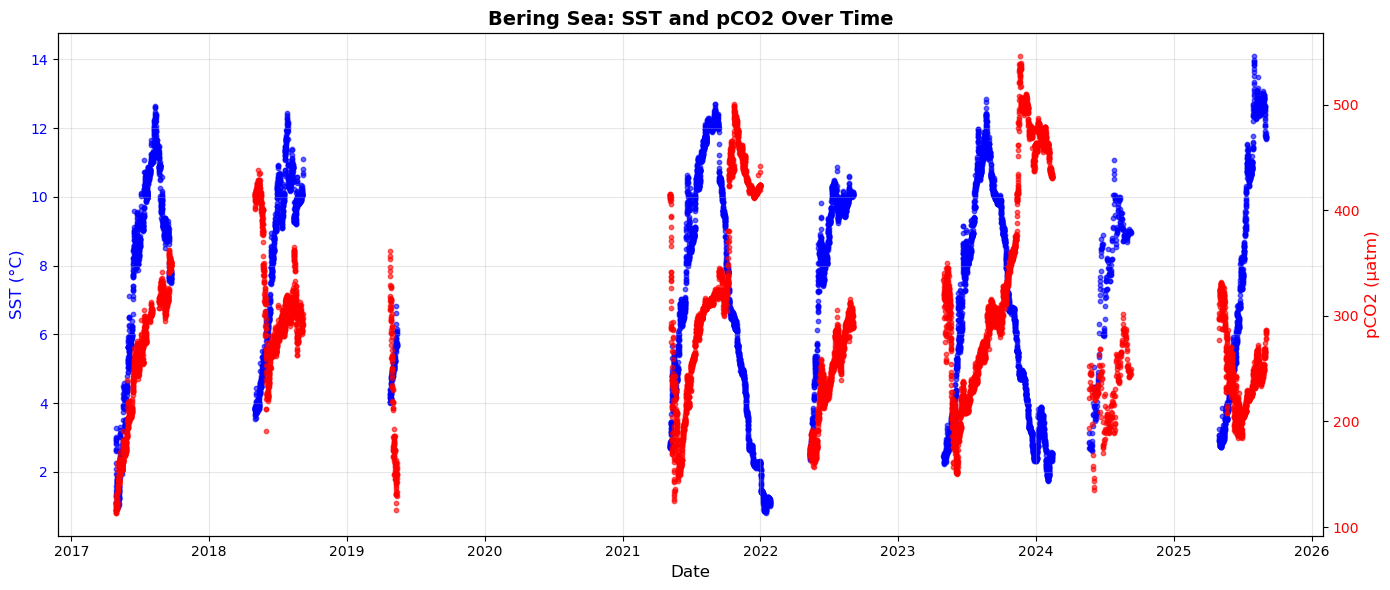

✓ Saved: 01_bering_sea_timeseries.png
  Bering Sea time series - SST (blue) and pCO2 (red)
Plotted 9206 points - gaps show missing data


In [37]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Scatter plot for SST
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('SST (°C)', color='blue', fontsize=12)
ax1.scatter(bering_clean['Date'], bering_clean['SST (C)'], color='blue', s=10, alpha=0.6, label='SST')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

# Second axis: pCO2
ax2 = ax1.twinx()
ax2.set_ylabel('pCO2 (μatm)', color='red', fontsize=12)
ax2.scatter(bering_clean['Date'], bering_clean['pCO2 SW (sat) uatm'], color='red', s=10, alpha=0.6, label='pCO2')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Bering Sea: SST and pCO2 Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

save_plot(fig, '01_bering_sea_timeseries.png', 'Bering Sea time series - SST (blue) and pCO2 (red)')
print(f"Plotted {bering_clean.shape[0]} points - gaps show missing data")

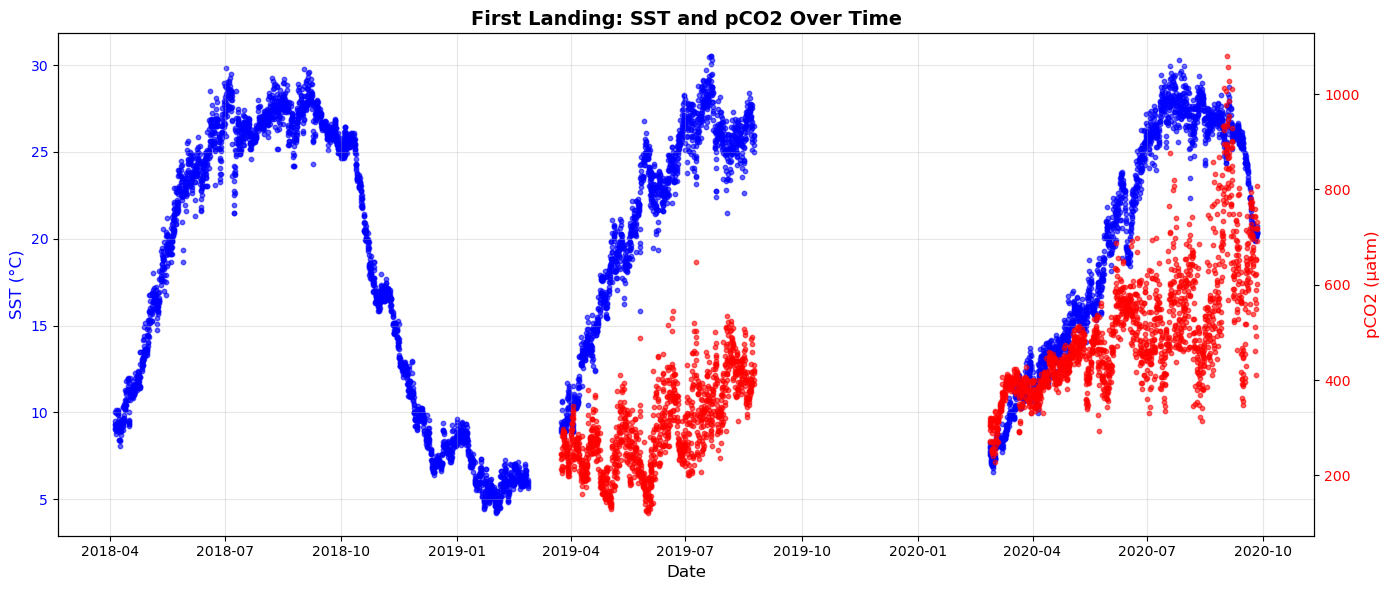

✓ Saved: 02_first_landing_timeseries.png
  First Landing time series
First Landing: 5649 data points


In [38]:
# First Landing
location = "First Landing"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'], format='mixed')
location_clean = location_clean.sort_values('Date')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('SST (°C)', color='blue', fontsize=12)
ax1.scatter(location_clean['Date'], location_clean['SST (C)'], color='blue', s=10, alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('pCO2 (μatm)', color='red', fontsize=12)
ax2.scatter(location_clean['Date'], location_clean['pCO2 SW (sat) uatm'], color='red', s=10, alpha=0.6)
ax2.tick_params(axis='y', labelcolor='red')

plt.title(f'{location}: SST and pCO2 Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

save_plot(fig, '02_first_landing_timeseries.png', 'First Landing time series')
print(f"{location}: {len(location_clean)} data points")

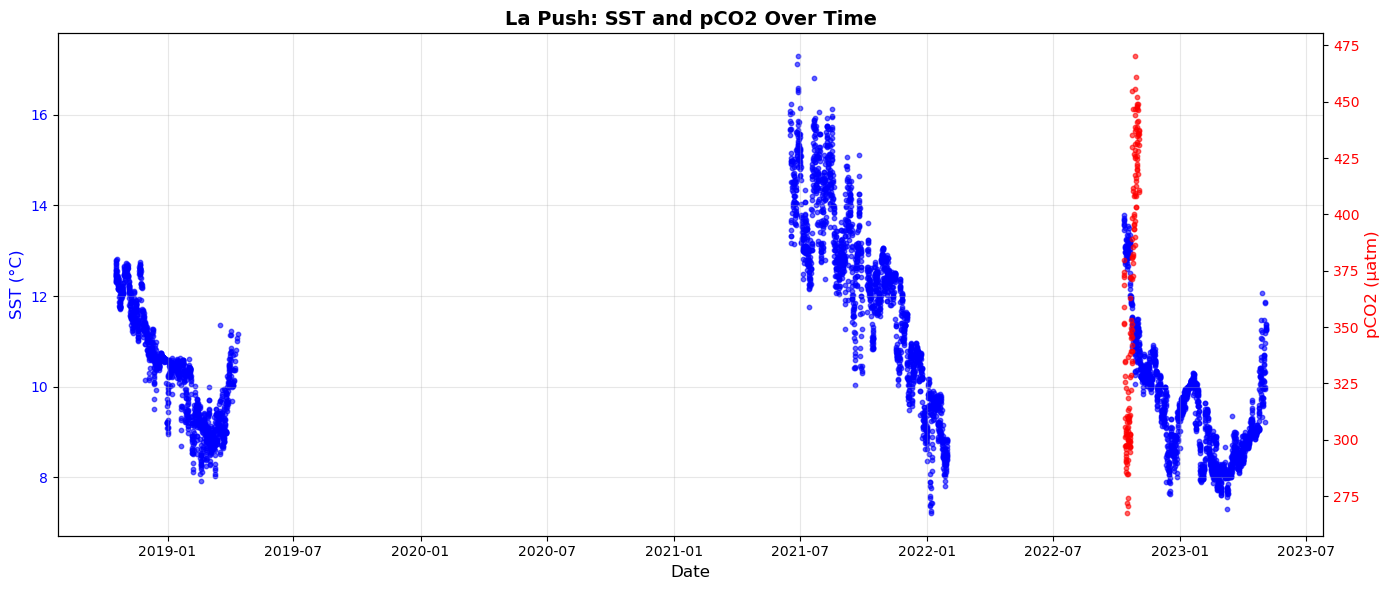

✓ Saved: 03_la_push_timeseries.png
  La Push time series
La Push: 5177 data points


In [39]:
# La Push
location = "La Push"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'], format='mixed')
location_clean = location_clean.sort_values('Date')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('SST (°C)', color='blue', fontsize=12)
ax1.scatter(location_clean['Date'], location_clean['SST (C)'], color='blue', s=10, alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('pCO2 (μatm)', color='red', fontsize=12)
ax2.scatter(location_clean['Date'], location_clean['pCO2 SW (sat) uatm'], color='red', s=10, alpha=0.6)
ax2.tick_params(axis='y', labelcolor='red')

plt.title(f'{location}: SST and pCO2 Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

save_plot(fig, '03_la_push_timeseries.png', 'La Push time series')
print(f"{location}: {len(location_clean)} data points")

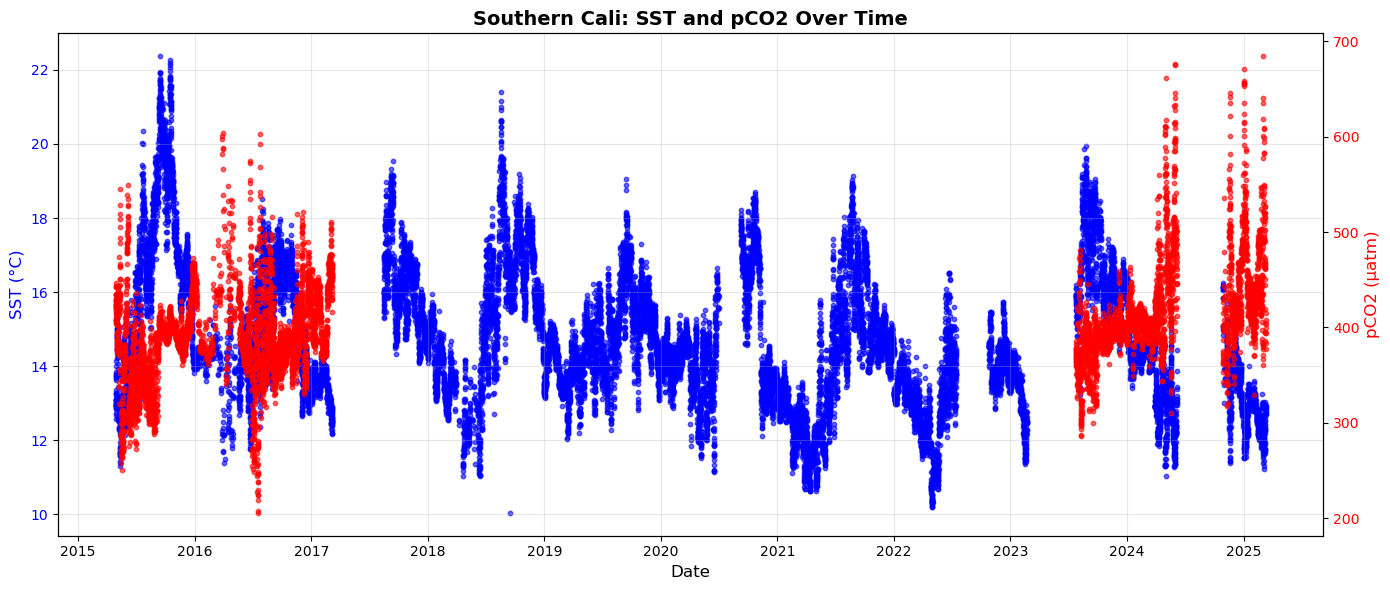

✓ Saved: 04_southern_cali_timeseries.png
  Southern California time series
Southern Cali: 23874 data points


In [40]:
# Southern Cali
location = "Southern Cali"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'], format='mixed')
location_clean = location_clean.sort_values('Date')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('SST (°C)', color='blue', fontsize=12)
ax1.scatter(location_clean['Date'], location_clean['SST (C)'], color='blue', s=10, alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('pCO2 (μatm)', color='red', fontsize=12)
ax2.scatter(location_clean['Date'], location_clean['pCO2 SW (sat) uatm'], color='red', s=10, alpha=0.6)
ax2.tick_params(axis='y', labelcolor='red')

plt.title(f'{location}: SST and pCO2 Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

save_plot(fig, '04_southern_cali_timeseries.png', 'Southern California time series')
print(f"{location}: {len(location_clean)} data points")

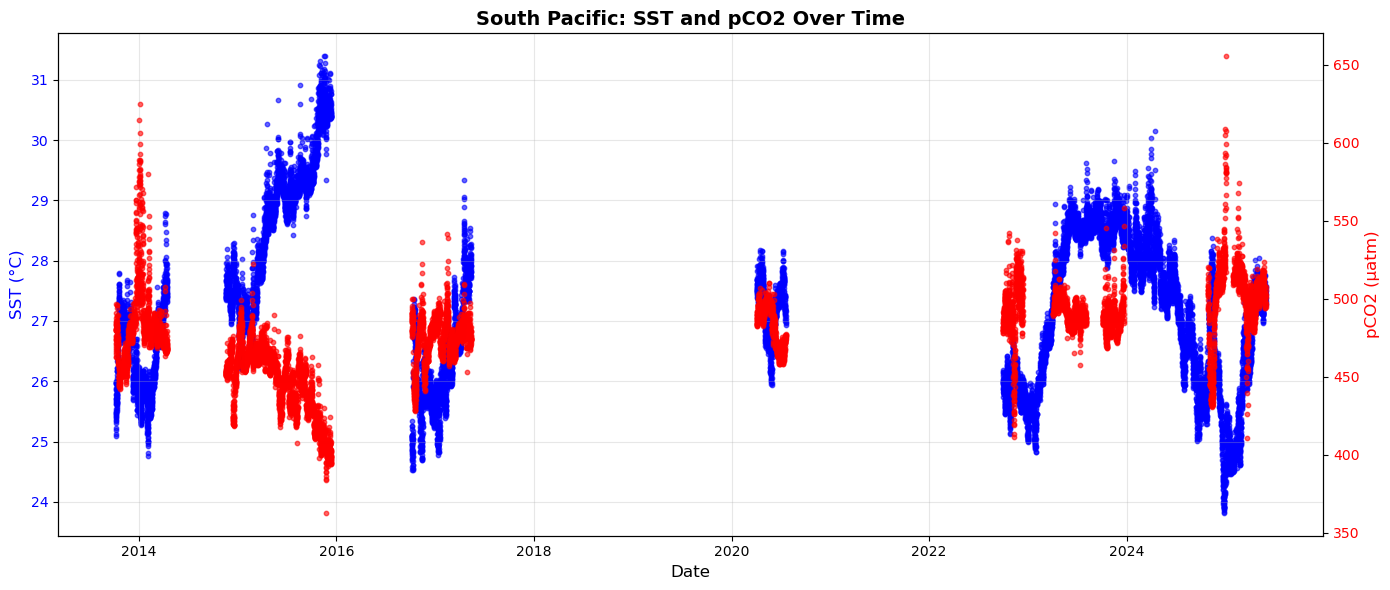

✓ Saved: 05_south_pacific_timeseries.png
  South Pacific time series
South Pacific: 21331 data points


In [41]:
# South Pacific
location = "South Pacific"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'], format='mixed')
location_clean = location_clean.sort_values('Date')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('SST (°C)', color='blue', fontsize=12)
ax1.scatter(location_clean['Date'], location_clean['SST (C)'], color='blue', s=10, alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('pCO2 (μatm)', color='red', fontsize=12)
ax2.scatter(location_clean['Date'], location_clean['pCO2 SW (sat) uatm'], color='red', s=10, alpha=0.6)
ax2.tick_params(axis='y', labelcolor='red')

plt.title(f'{location}: SST and pCO2 Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

save_plot(fig, '05_south_pacific_timeseries.png', 'South Pacific time series')
print(f"{location}: {len(location_clean)} data points")

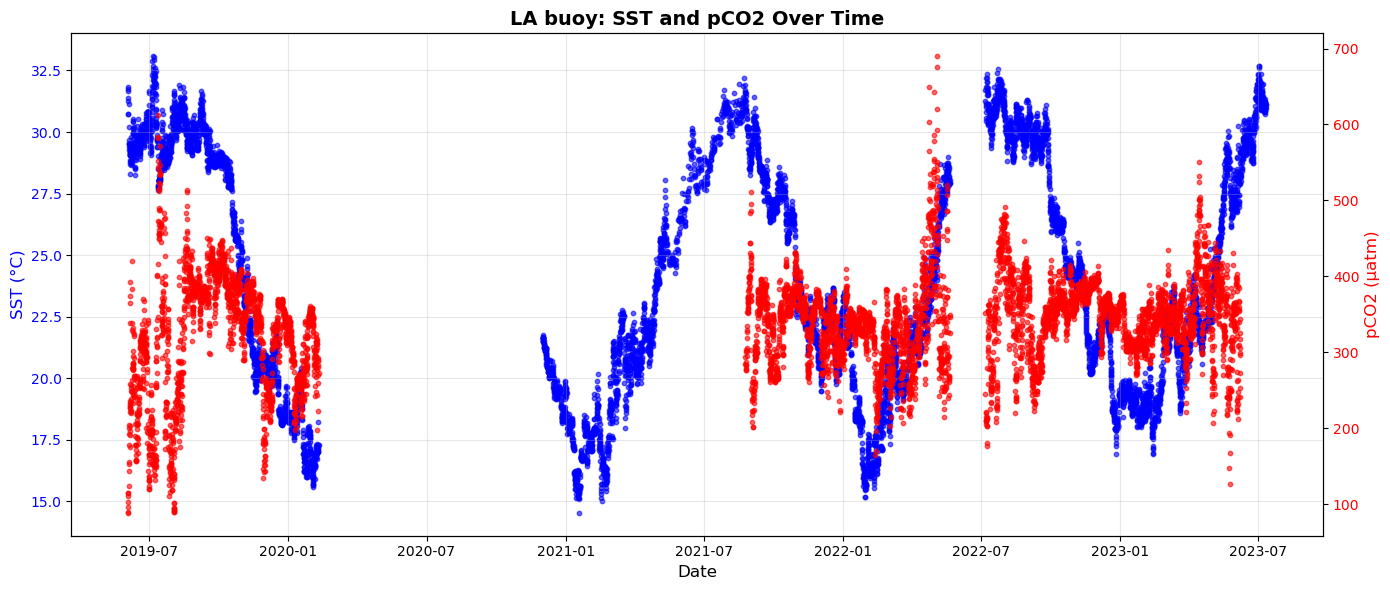

✓ Saved: 06_la_buoy_timeseries.png
  LA buoy time series
LA buoy: 11997 data points


In [42]:
# LA buoy
location = "LA buoy"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'], format='mixed')
location_clean = location_clean.sort_values('Date')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('SST (°C)', color='blue', fontsize=12)
ax1.scatter(location_clean['Date'], location_clean['SST (C)'], color='blue', s=10, alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('pCO2 (μatm)', color='red', fontsize=12)
ax2.scatter(location_clean['Date'], location_clean['pCO2 SW (sat) uatm'], color='red', s=10, alpha=0.6)
ax2.tick_params(axis='y', labelcolor='red')

plt.title(f'{location}: SST and pCO2 Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

save_plot(fig, '06_la_buoy_timeseries.png', 'LA buoy time series')
print(f"{location}: {len(location_clean)} data points")

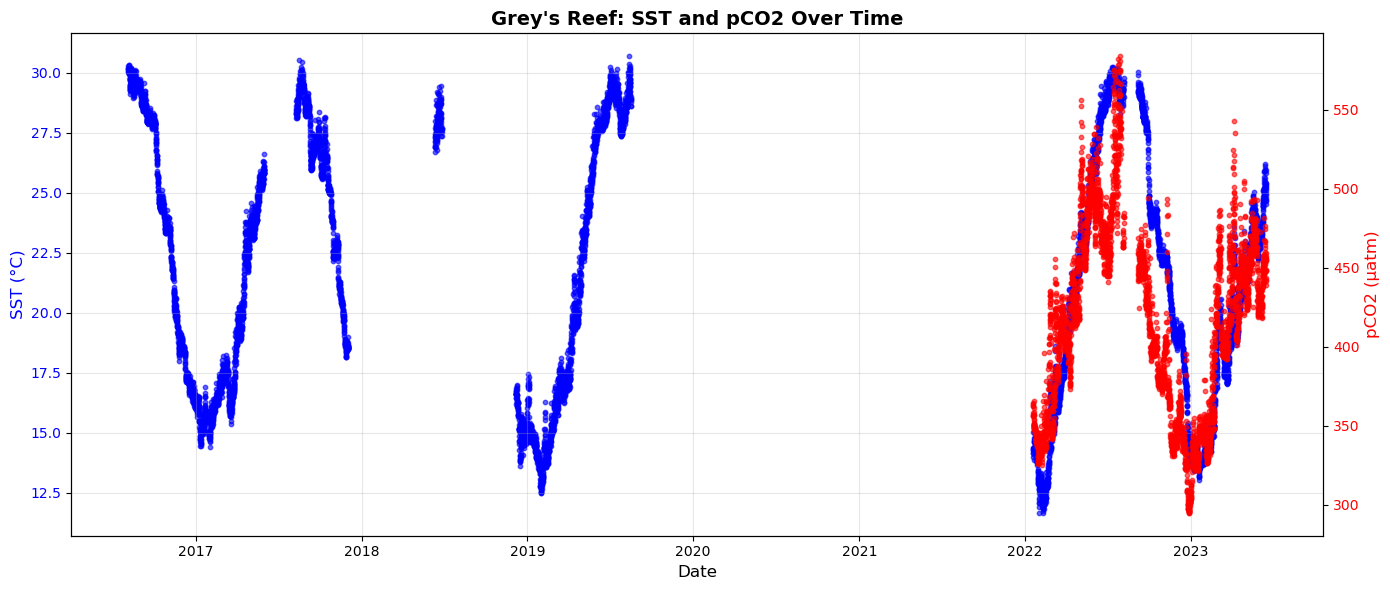

✓ Saved: 07_greys_reef_timeseries.png
  Grey's Reef time series
Grey's Reef: 15337 data points


In [43]:
# Grey's Reef
location = "Grey's Reef"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'], format='mixed')
location_clean = location_clean.sort_values('Date')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('SST (°C)', color='blue', fontsize=12)
ax1.scatter(location_clean['Date'], location_clean['SST (C)'], color='blue', s=10, alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('pCO2 (μatm)', color='red', fontsize=12)
ax2.scatter(location_clean['Date'], location_clean['pCO2 SW (sat) uatm'], color='red', s=10, alpha=0.6)
ax2.tick_params(axis='y', labelcolor='red')

plt.title(f'{location}: SST and pCO2 Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

save_plot(fig, '07_greys_reef_timeseries.png', "Grey's Reef time series")
print(f"{location}: {len(location_clean)} data points")

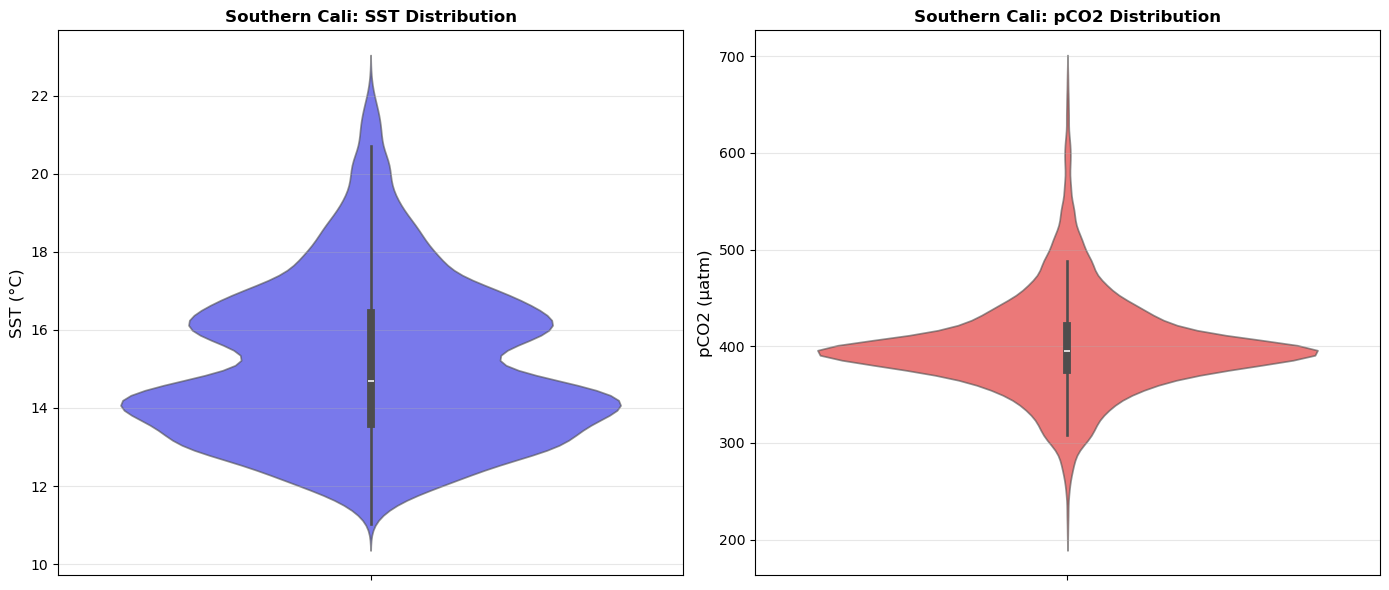

✓ Saved: 08_southern_cali_distribution.png
  Southern California distribution
Southern Cali: 8099 paired data points
  SST: mean=15.11°C, std=2.03°C
  pCO2: mean=400.25 μatm, std=50.47 μatm


In [44]:
# Southern Cali - Distribution
location = "Southern Cali"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'], format='mixed')
location_clean = location_clean.sort_values('Date')

# Remove NaN for distribution analysis
location_clean_drop = location_clean.dropna(subset=['SST (C)', 'pCO2 SW (sat) uatm'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot for SST
sns.violinplot(y=location_clean_drop['SST (C)'], ax=axes[0], color='blue', alpha=0.6)
axes[0].set_ylabel('SST (°C)', fontsize=12)
axes[0].set_xlabel('')
axes[0].set_title(f'{location}: SST Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Violin plot for pCO2
sns.violinplot(y=location_clean_drop['pCO2 SW (sat) uatm'], ax=axes[1], color='red', alpha=0.6)
axes[1].set_ylabel('pCO2 (μatm)', fontsize=12)
axes[1].set_xlabel('')
axes[1].set_title(f'{location}: pCO2 Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

fig.tight_layout()
plt.show()

save_plot(fig, '08_southern_cali_distribution.png', 'Southern California distribution')
print(f"{location}: {len(location_clean_drop)} paired data points")
print(f"  SST: mean={location_clean_drop['SST (C)'].mean():.2f}°C, std={location_clean_drop['SST (C)'].std():.2f}°C")
print(f"  pCO2: mean={location_clean_drop['pCO2 SW (sat) uatm'].mean():.2f} μatm, std={location_clean_drop['pCO2 SW (sat) uatm'].std():.2f} μatm")

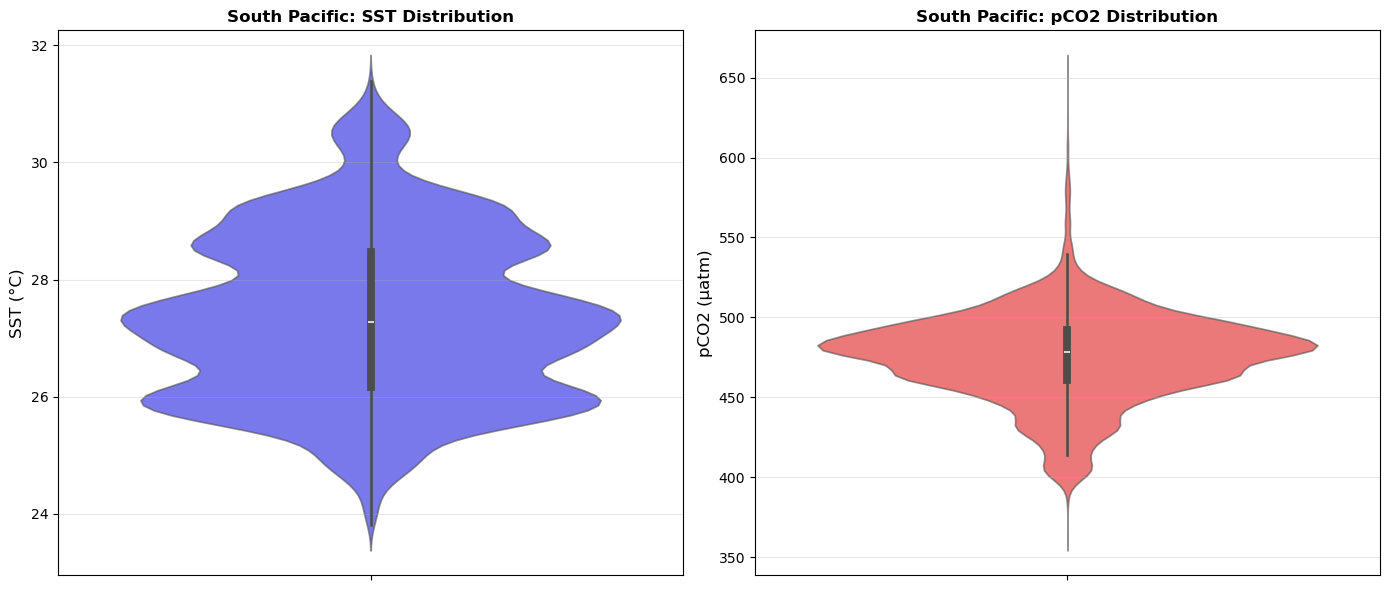

✓ Saved: 09_south_pacific_distribution.png
  South Pacific distribution
South Pacific: 10843 paired data points
  SST: mean=27.35°C, std=1.41°C
  pCO2: mean=475.35 μatm, std=27.74 μatm


In [45]:
# South Pacific - Distribution
location = "South Pacific"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'], format='mixed')
location_clean = location_clean.sort_values('Date')

# Remove NaN for distribution analysis
location_clean_drop = location_clean.dropna(subset=['SST (C)', 'pCO2 SW (sat) uatm'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot for SST
sns.violinplot(y=location_clean_drop['SST (C)'], ax=axes[0], color='blue', alpha=0.6)
axes[0].set_ylabel('SST (°C)', fontsize=12)
axes[0].set_xlabel('')
axes[0].set_title(f'{location}: SST Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Violin plot for pCO2
sns.violinplot(y=location_clean_drop['pCO2 SW (sat) uatm'], ax=axes[1], color='red', alpha=0.6)
axes[1].set_ylabel('pCO2 (μatm)', fontsize=12)
axes[1].set_xlabel('')
axes[1].set_title(f'{location}: pCO2 Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

fig.tight_layout()
plt.show()

save_plot(fig, '09_south_pacific_distribution.png', 'South Pacific distribution')
print(f"{location}: {len(location_clean_drop)} paired data points")
print(f"  SST: mean={location_clean_drop['SST (C)'].mean():.2f}°C, std={location_clean_drop['SST (C)'].std():.2f}°C")
print(f"  pCO2: mean={location_clean_drop['pCO2 SW (sat) uatm'].mean():.2f} μatm, std={location_clean_drop['pCO2 SW (sat) uatm'].std():.2f} μatm")

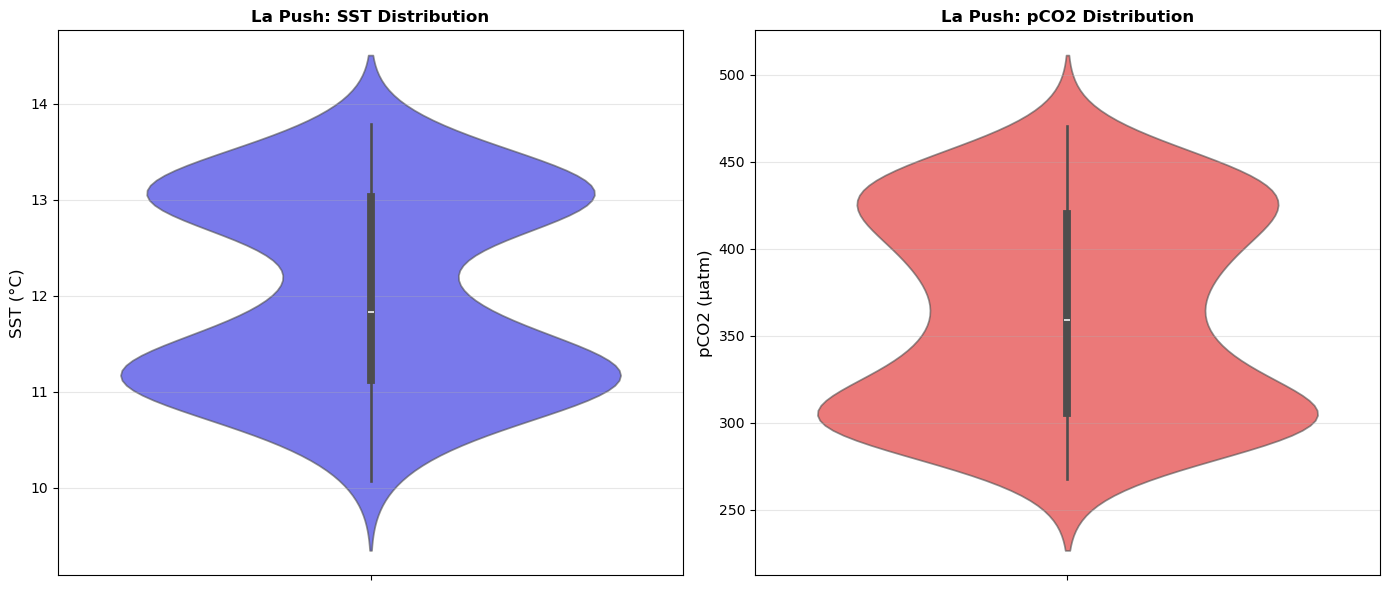

✓ Saved: 10_la_push_distribution.png
  La Push distribution
La Push: 175 paired data points
  SST: mean=12.02°C, std=1.01°C
  pCO2: mean=363.63 μatm, std=57.63 μatm


In [46]:
# La Push - Distribution
location = "La Push"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'], format='mixed')
location_clean = location_clean.sort_values('Date')

# Remove NaN for distribution analysis
location_clean_drop = location_clean.dropna(subset=['SST (C)', 'pCO2 SW (sat) uatm'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot for SST
sns.violinplot(y=location_clean_drop['SST (C)'], ax=axes[0], color='blue', alpha=0.6)
axes[0].set_ylabel('SST (°C)', fontsize=12)
axes[0].set_xlabel('')
axes[0].set_title(f'{location}: SST Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Violin plot for pCO2
sns.violinplot(y=location_clean_drop['pCO2 SW (sat) uatm'], ax=axes[1], color='red', alpha=0.6)
axes[1].set_ylabel('pCO2 (μatm)', fontsize=12)
axes[1].set_xlabel('')
axes[1].set_title(f'{location}: pCO2 Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

fig.tight_layout()
plt.show()

save_plot(fig, '10_la_push_distribution.png', 'La Push distribution')
print(f"{location}: {len(location_clean_drop)} paired data points")
print(f"  SST: mean={location_clean_drop['SST (C)'].mean():.2f}°C, std={location_clean_drop['SST (C)'].std():.2f}°C")
print(f"  pCO2: mean={location_clean_drop['pCO2 SW (sat) uatm'].mean():.2f} μatm, std={location_clean_drop['pCO2 SW (sat) uatm'].std():.2f} μatm")

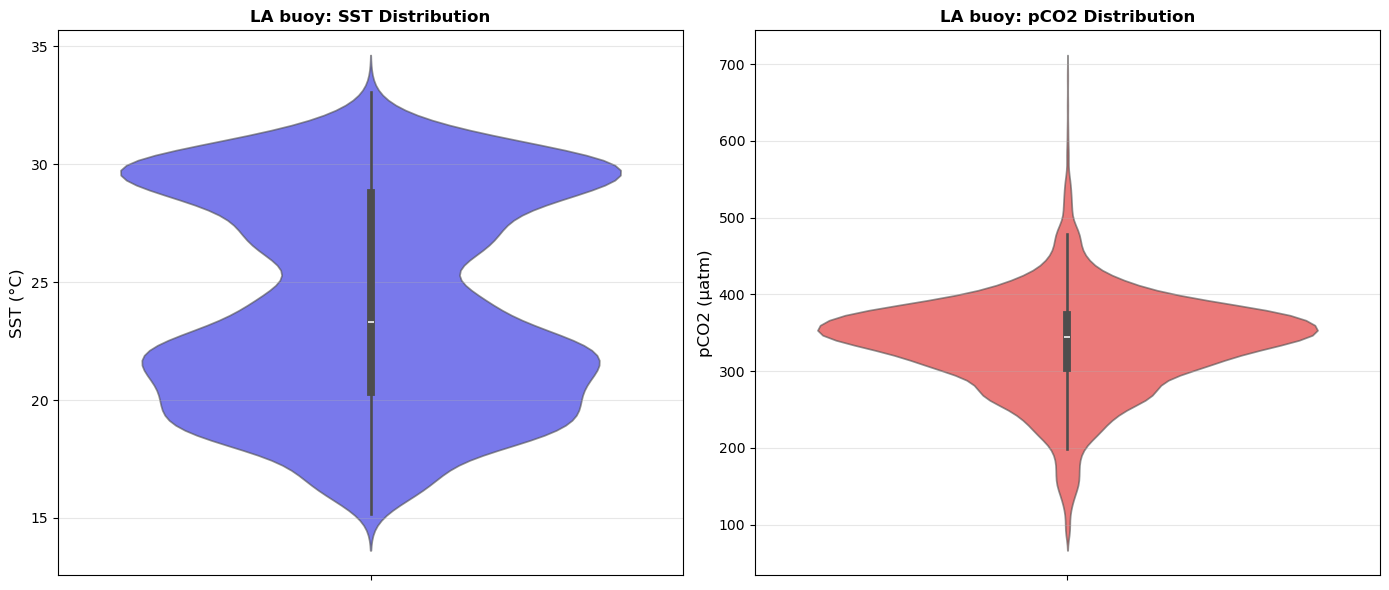

✓ Saved: 11_la_buoy_distribution.png
  LA buoy distribution
LA buoy: 6829 paired data points
  SST: mean=24.18°C, std=4.52°C
  pCO2: mean=336.31 μatm, std=63.52 μatm


In [47]:
# LA buoy - Distribution
location = "LA buoy"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'], format='mixed')
location_clean = location_clean.sort_values('Date')

# Remove NaN for distribution analysis
location_clean_drop = location_clean.dropna(subset=['SST (C)', 'pCO2 SW (sat) uatm'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot for SST
sns.violinplot(y=location_clean_drop['SST (C)'], ax=axes[0], color='blue', alpha=0.6)
axes[0].set_ylabel('SST (°C)', fontsize=12)
axes[0].set_xlabel('')
axes[0].set_title(f'{location}: SST Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Violin plot for pCO2
sns.violinplot(y=location_clean_drop['pCO2 SW (sat) uatm'], ax=axes[1], color='red', alpha=0.6)
axes[1].set_ylabel('pCO2 (μatm)', fontsize=12)
axes[1].set_xlabel('')
axes[1].set_title(f'{location}: pCO2 Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

fig.tight_layout()
plt.show()

save_plot(fig, '11_la_buoy_distribution.png', 'LA buoy distribution')
print(f"{location}: {len(location_clean_drop)} paired data points")
print(f"  SST: mean={location_clean_drop['SST (C)'].mean():.2f}°C, std={location_clean_drop['SST (C)'].std():.2f}°C")
print(f"  pCO2: mean={location_clean_drop['pCO2 SW (sat) uatm'].mean():.2f} μatm, std={location_clean_drop['pCO2 SW (sat) uatm'].std():.2f} μatm")

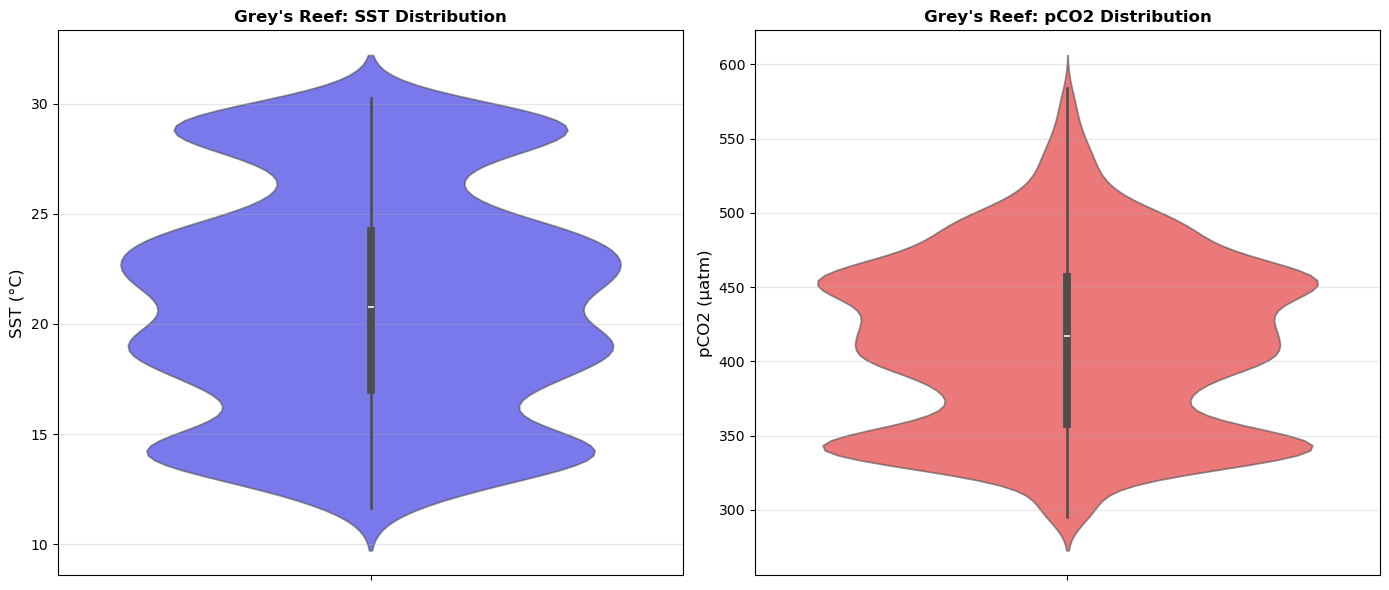

✓ Saved: 12_greys_reef_distribution.png
  Grey's Reef distribution
Grey's Reef: 3889 paired data points
  SST: mean=20.89°C, std=5.08°C
  pCO2: mean=414.17 μatm, std=58.33 μatm


In [48]:
# Grey's Reef - Distribution
location = "Grey's Reef"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'], format='mixed')
location_clean = location_clean.sort_values('Date')

# Remove NaN for distribution analysis
location_clean_drop = location_clean.dropna(subset=['SST (C)', 'pCO2 SW (sat) uatm'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot for SST
sns.violinplot(y=location_clean_drop['SST (C)'], ax=axes[0], color='blue', alpha=0.6)
axes[0].set_ylabel('SST (°C)', fontsize=12)
axes[0].set_xlabel('')
axes[0].set_title(f'{location}: SST Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Violin plot for pCO2
sns.violinplot(y=location_clean_drop['pCO2 SW (sat) uatm'], ax=axes[1], color='red', alpha=0.6)
axes[1].set_ylabel('pCO2 (μatm)', fontsize=12)
axes[1].set_xlabel('')
axes[1].set_title(f'{location}: pCO2 Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

fig.tight_layout()
plt.show()

save_plot(fig, '12_greys_reef_distribution.png', "Grey's Reef distribution")
print(f"{location}: {len(location_clean_drop)} paired data points")
print(f"  SST: mean={location_clean_drop['SST (C)'].mean():.2f}°C, std={location_clean_drop['SST (C)'].std():.2f}°C")
print(f"  pCO2: mean={location_clean_drop['pCO2 SW (sat) uatm'].mean():.2f} μatm, std={location_clean_drop['pCO2 SW (sat) uatm'].std():.2f} μatm")

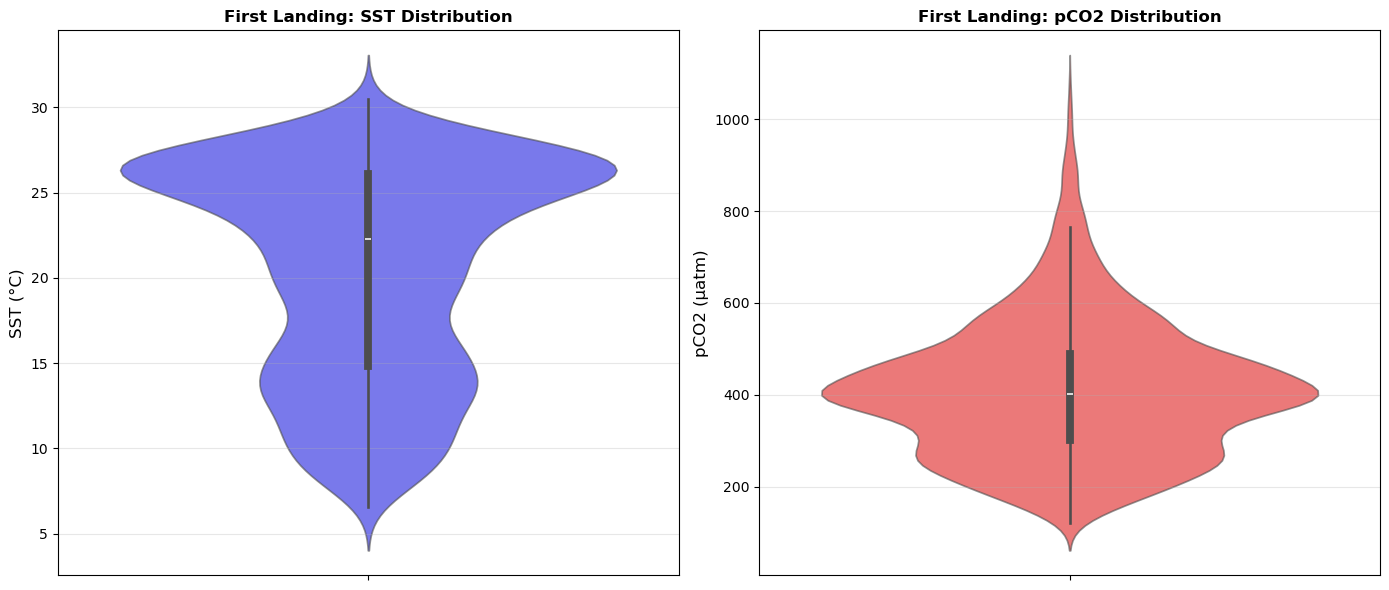

✓ Saved: 13_first_landing_distribution.png
  First Landing distribution
First Landing: 2935 paired data points
  SST: mean=20.49°C, std=6.32°C
  pCO2: mean=411.39 μatm, std=149.12 μatm


In [49]:
# First Landing - Distribution
location = "First Landing"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'], format='mixed')
location_clean = location_clean.sort_values('Date')

# Remove NaN for distribution analysis
location_clean_drop = location_clean.dropna(subset=['SST (C)', 'pCO2 SW (sat) uatm'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot for SST
sns.violinplot(y=location_clean_drop['SST (C)'], ax=axes[0], color='blue', alpha=0.6)
axes[0].set_ylabel('SST (°C)', fontsize=12)
axes[0].set_xlabel('')
axes[0].set_title(f'{location}: SST Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Violin plot for pCO2
sns.violinplot(y=location_clean_drop['pCO2 SW (sat) uatm'], ax=axes[1], color='red', alpha=0.6)
axes[1].set_ylabel('pCO2 (μatm)', fontsize=12)
axes[1].set_xlabel('')
axes[1].set_title(f'{location}: pCO2 Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

fig.tight_layout()
plt.show()

save_plot(fig, '13_first_landing_distribution.png', 'First Landing distribution')
print(f"{location}: {len(location_clean_drop)} paired data points")
print(f"  SST: mean={location_clean_drop['SST (C)'].mean():.2f}°C, std={location_clean_drop['SST (C)'].std():.2f}°C")
print(f"  pCO2: mean={location_clean_drop['pCO2 SW (sat) uatm'].mean():.2f} μatm, std={location_clean_drop['pCO2 SW (sat) uatm'].std():.2f} μatm")

C:\Users\Owner\AppData\Local\Temp\ipykernel_18660\2777983057.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  location_clean['Date'] = pd.to_datetime(location_clean['Date'])


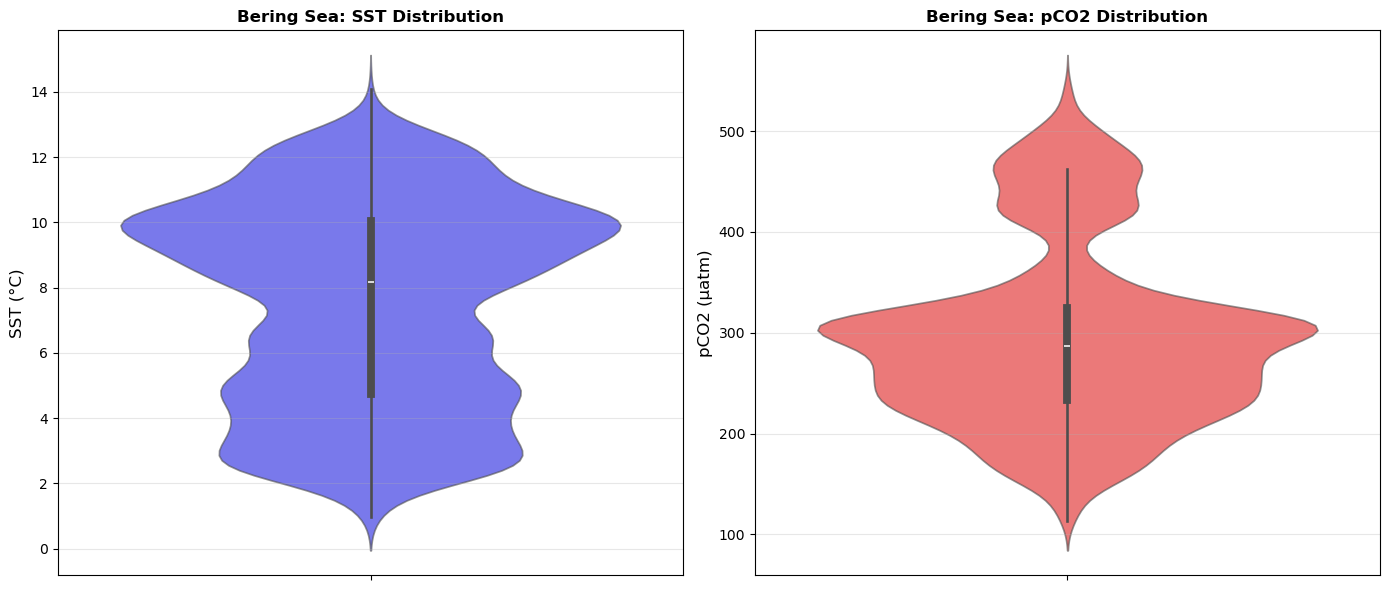

✓ Saved: 14_bering_sea_distribution.png
  Bering Sea distribution
Bering Sea: 8359 paired data points
  SST: mean=7.51°C, std=3.15°C
  pCO2: mean=295.70 μatm, std=88.93 μatm


In [50]:
# Bering Sea - Distribution
location = "Bering Sea"
location_data = load_location_data(location)
location_clean = location_data.copy()
location_clean['SST (C)'] = location_clean['SST (C)'].replace(-999.0, np.nan)
location_clean['pCO2 SW (sat) uatm'] = location_clean['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
location_clean['Date'] = pd.to_datetime(location_clean['Date'])
location_clean = location_clean.sort_values('Date')

# Remove NaN for distribution analysis
location_clean_drop = location_clean.dropna(subset=['SST (C)', 'pCO2 SW (sat) uatm'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot for SST
sns.violinplot(y=location_clean_drop['SST (C)'], ax=axes[0], color='blue', alpha=0.6)
axes[0].set_ylabel('SST (°C)', fontsize=12)
axes[0].set_xlabel('')
axes[0].set_title(f'{location}: SST Distribution', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Violin plot for pCO2
sns.violinplot(y=location_clean_drop['pCO2 SW (sat) uatm'], ax=axes[1], color='red', alpha=0.6)
axes[1].set_ylabel('pCO2 (μatm)', fontsize=12)
axes[1].set_xlabel('')
axes[1].set_title(f'{location}: pCO2 Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

fig.tight_layout()
plt.show()

save_plot(fig, '14_bering_sea_distribution.png', 'Bering Sea distribution')
print(f"{location}: {len(location_clean_drop)} paired data points")
print(f"  SST: mean={location_clean_drop['SST (C)'].mean():.2f}°C, std={location_clean_drop['SST (C)'].std():.2f}°C")
print(f"  pCO2: mean={location_clean_drop['pCO2 SW (sat) uatm'].mean():.2f} μatm, std={location_clean_drop['pCO2 SW (sat) uatm'].std():.2f} μatm")

In [51]:
# Load and combine all location data for comparison
all_data = []

for location in sorted(locations):
    location_data = load_location_data(location)
    location_data['SST (C)'] = location_data['SST (C)'].replace(-999.0, np.nan)
    location_data['pCO2 SW (sat) uatm'] = location_data['pCO2 SW (sat) uatm'].replace(-999.0, np.nan)
    location_data['Date'] = pd.to_datetime(location_data['Date'], format='mixed', errors='coerce')
    location_data = location_data.sort_values('Date')
    all_data.append(location_data)

# Combine all locations
combined_all = pd.concat(all_data, ignore_index=True)
combined_clean = combined_all.dropna(subset=['SST (C)', 'pCO2 SW (sat) uatm'])

print(f"Total data points across all locations: {len(combined_clean)}")
print(f"Locations included: {', '.join(sorted(locations))}")


Total data points across all locations: 41129
Locations included: Bering Sea, First Landing, Grey's Reef, LA buoy, La Push, South Pacific, Southern Cali


In [52]:
fig.tight_layout()
plt.show()

save_plot(fig, '15_all_locations_comparison.png', 'SST and pCO2 across all locations')


✓ Saved: 15_all_locations_comparison.png
  SST and pCO2 across all locations


In [53]:
# Extract coordinates for each location and create a mapping
location_coords = {}

for location in sorted(locations):
    location_data = load_location_data(location)
    
    # Check what coordinate columns exist
    coord_cols = [col for col in location_data.columns if 'lat' in col.lower() or 'lon' in col.lower()]
    
    if coord_cols:
        # Get the first available lat/lon columns
        lat_col = [col for col in coord_cols if 'lat' in col.lower()][0] if any('lat' in col.lower() for col in coord_cols) else None
        lon_col = [col for col in coord_cols if 'lon' in col.lower()][0] if any('lon' in col.lower() for col in coord_cols) else None
        
        if lat_col and lon_col:
            # Get first non-null coordinate pair
            valid_coords = location_data[[lat_col, lon_col]].dropna()
            if len(valid_coords) > 0:
                lat = valid_coords[lat_col].iloc[0]
                lon = valid_coords[lon_col].iloc[0]
                location_coords[location] = {'lat': lat, 'lon': lon}
                print(f"{location}: Lat={lat:.2f}, Lon={lon:.2f}")

print(f"\nFound coordinates for {len(location_coords)} locations")


Bering Sea: Lat=56.86, Lon=-164.02
First Landing: Lat=37.00, Lon=-76.09
Grey's Reef: Lat=31.39, Lon=-80.87
LA buoy: Lat=28.87, Lon=-90.48
La Push: Lat=47.97, Lon=-124.95
South Pacific: Lat=-0.00, Lon=-154.16
Southern Cali: Lat=34.31, Lon=-120.80

Found coordinates for 7 locations


C:\Users\Owner\AppData\Local\Temp\ipykernel_18660\2752809991.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_sorted, x='location', y='SST (C)', ax=axes[0], palette='Blues', order=sorted_locations)
C:\Users\Owner\AppData\Local\Temp\ipykernel_18660\2752809991.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(location_labels, rotation=45, ha='right', fontsize=10)
C:\Users\Owner\AppData\Local\Temp\ipykernel_18660\2752809991.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_sorted, x='location', y='pCO2 SW (sat) uatm', ax=axes[1], palette='Reds', ord

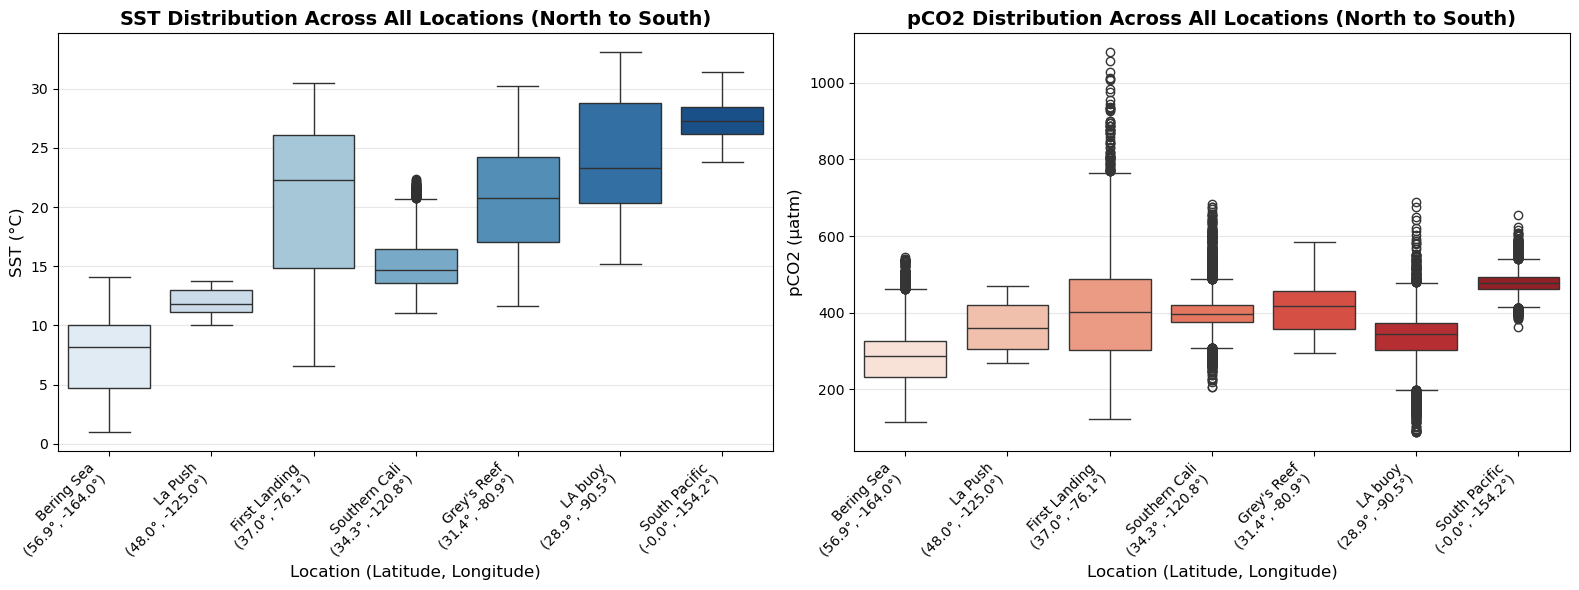

✓ Saved: 16_geographic_sorted.png
  Locations sorted north-to-south by latitude

Geographic ordering (North to South):
  1. Bering Sea: 56.86°N, -164.02°W
  2. La Push: 47.97°N, -124.95°W
  3. First Landing: 37.00°N, -76.09°W
  4. Southern Cali: 34.31°N, -120.80°W
  5. Grey's Reef: 31.39°N, -80.87°W
  6. LA buoy: 28.87°N, -90.48°W
  7. South Pacific: -0.00°N, -154.16°W


In [54]:
# Create a sorted list of locations by latitude (north to south)
if location_coords:
    sorted_locations = sorted(location_coords.keys(), key=lambda x: location_coords[x]['lat'], reverse=True)
    
    # Create labels with coordinates
    location_labels = [f"{loc}\n({location_coords[loc]['lat']:.1f}°, {location_coords[loc]['lon']:.1f}°)" 
                       for loc in sorted_locations]
    
    # Filter combined_clean to only include sorted locations
    combined_sorted = combined_clean[combined_clean['location'].isin(sorted_locations)].copy()
    
    # Reorder by our sorted list (for plotting)
    combined_sorted['location'] = pd.Categorical(combined_sorted['location'], 
                                                   categories=sorted_locations, 
                                                   ordered=True)
    combined_sorted = combined_sorted.sort_values('location')
    
    # Create box plots sorted by geography
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Box plot for SST
    sns.boxplot(data=combined_sorted, x='location', y='SST (C)', ax=axes[0], palette='Blues', order=sorted_locations)
    axes[0].set_xlabel('Location (Latitude, Longitude)', fontsize=12)
    axes[0].set_ylabel('SST (°C)', fontsize=12)
    axes[0].set_title('SST Distribution Across All Locations (North to South)', fontsize=14, fontweight='bold')
    axes[0].set_xticklabels(location_labels, rotation=45, ha='right', fontsize=10)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Box plot for pCO2
    sns.boxplot(data=combined_sorted, x='location', y='pCO2 SW (sat) uatm', ax=axes[1], palette='Reds', order=sorted_locations)
    axes[1].set_xlabel('Location (Latitude, Longitude)', fontsize=12)
    axes[1].set_ylabel('pCO2 (μatm)', fontsize=12)
    axes[1].set_title('pCO2 Distribution Across All Locations (North to South)', fontsize=14, fontweight='bold')
    axes[1].set_xticklabels(location_labels, rotation=45, ha='right', fontsize=10)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    fig.tight_layout()
    plt.show()
    
    save_plot(fig, '16_geographic_sorted.png', 'Locations sorted north-to-south by latitude')
    print("\nGeographic ordering (North to South):")
    for i, loc in enumerate(sorted_locations, 1):
        print(f"  {i}. {loc}: {location_coords[loc]['lat']:.2f}°N, {location_coords[loc]['lon']:.2f}°W")
else:
    print("Coordinates not found in data. Displaying original plot.")


## Comparative Analysis Across All Locations
See how temperature and pCO2 distributions differ between the 7 buoy sites by plotting them all together.


## Distribution Analysis
Violin plots show the distribution of values at each location. This complements the time series by revealing what temperature and CO2 ranges are typical, and how spread out the values are.
